In [1]:
from utils.dataloader import DataPartitions, DataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
plotsize = 15

partitions = DataPartitions(
    past_frames=6,
    future_frames=2,
    root="../datasets/baganza/10min/",
    partial=1
)

arda_ds = DataGenerator(
    root="../datasets/baganza/10min/",
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 3),
    output_dim=(partitions.future_frames, 256, 256, 2),
    batch_size=4,
    n_channels=1,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
)

In [4]:
X = arda_ds.get_X()
Y = arda_ds.get_Y()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


In [11]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

0.9997544288635254


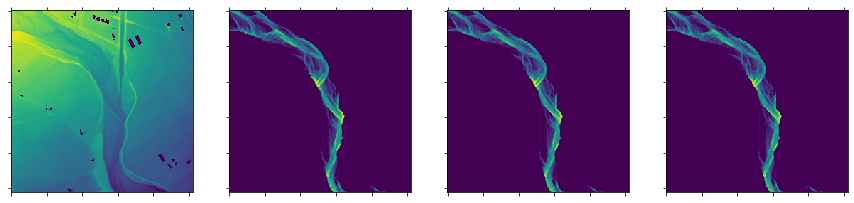

In [14]:
print(arda_ds.buffer_hit_ratio)

j = 3
i = 3

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(1, 2 + Y.shape[2], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

axs[0].matshow(X[j, i, 0, :, :, 2]) # btm
axs[1].matshow(X[j, i, 0, :, :, 0]) # primo frame

for i,frame in enumerate(Y[j,i]):   # y frames
    axs[i+2].matshow(frame[:, :, 0])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: 0.0
BTM min: 0.0
DEP max: 1.72461
VEL max: 2.4140360130909397
BTM max: 14.510099999999994


### Model

In [17]:
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

In [18]:
if th.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = th.device(dev) 

In [11]:
class ResNetBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride, kernel_size, padding):
        super(ResNetBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.Conv3d(in_filters, filters, kernel_size, stride, padding=padding)
        self.c2 = nn.Conv3d(filters, filters, kernel_size, padding=padding)
        self.c3 = nn.Conv3d(in_filters, filters, (1, 1, 1), stride)
        
        #self.bn = nn.BatchNorm3d(num_features=filters)

    def forward(self, x,):
        
        residual = x
        
        y = self.c1(x)

        #y = self.bn(y)
        y = self.activation(y)
        y = self.c2(y)
        #y = self.bn(y)

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            #residual = self.bn(residual)
            
        return self.activation(residual + y)


In [23]:
class Autoencoder(nn.Module):
    
    def __init__(self, channels):
        super(Autoencoder, self).__init__()

        kernel_size = 3
        padding = 1

        self.layers = nn.ModuleList([
            nn.Conv3d(channels, 8, kernel_size=kernel_size, stride=1, padding=padding),
            nn.AvgPool3d((1,2,2)),
            
            ResNetBlock(in_filters = 8, filters = 8, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(8, 16, (1,1,1)),
            ResNetBlock(in_filters = 16, filters = 16, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(16, 32, (1,1,1)),
            ResNetBlock(in_filters = 32, filters = 32, stride = (2,1,1), kernel_size=kernel_size, padding=padding),

            nn.Conv3d(32, 64, (1,1,1)),
            ResNetBlock(in_filters = 64, filters = 64, stride = 1, kernel_size=kernel_size, padding=padding),

            # ----------------------

            nn.ConvTranspose3d(64, 32, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=32),

            nn.ConvTranspose3d(32, 16, (2,2,2), stride=(2,2,2)),
            #nn.BatchNorm3d(num_features=16),

            nn.ConvTranspose3d(16, 8, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=8),

            nn.ConvTranspose3d(8, 8, (1,1,1), stride=(1,1,1)),
            #nn.BatchNorm3d(num_features=8),
            
            nn.ConvTranspose3d(8, 2, (1,1,1), stride=(1,1,1)),
        ])
    
    def forward(self, x, summary = False):
        
        if summary:
            print("==== Model Summary ====")
            print("{:<15s}{:>4s}".format("Block", "Output shape"))

        for i, l in enumerate(self.layers):
            x = l(x)
            
            if summary:
                print("{:<20s}{:>4s}".format(
                    str(l).split("(")[0],
                    str(x.shape).split("[")[1].split("]")[0]
                ))
        
        return x

In [24]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [29]:
net = Autoencoder(channels=3).to(device)
net(th.Tensor(np.random.random((16, 3, 6, 128, 128))).to(device), True).shape

==== Model Summary ====
Block          Output shape
Conv3d              16, 8, 6, 128, 128
AvgPool3d           16, 8, 6, 64, 64
ResNetBlock         16, 8, 3, 32, 32
Conv3d              16, 16, 3, 32, 32
ResNetBlock         16, 16, 2, 16, 16
Conv3d              16, 32, 2, 16, 16
ResNetBlock         16, 32, 1, 16, 16
Conv3d              16, 64, 1, 16, 16
ResNetBlock         16, 64, 1, 16, 16
ConvTranspose3d     16, 32, 1, 32, 32
ConvTranspose3d     16, 16, 2, 64, 64
ConvTranspose3d     16, 8, 2, 128, 128
ConvTranspose3d     16, 8, 2, 128, 128
ConvTranspose3d     16, 2, 2, 128, 128


torch.Size([16, 2, 2, 128, 128])

In [30]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [16]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [17]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [18]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [19]:
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [19]:
import pytorch_ssim
from torch.autograd import Variable

def reverse_ssim_frame(frame1, frame2):
    frame1 = Variable(th.unsqueeze(th.unsqueeze(th.Tensor(frame1), 0),0))
    frame2 = Variable(th.unsqueeze(th.unsqueeze(th.Tensor(frame2),0),0))

    if th.cuda.is_available():
        frame1 = frame1.cuda()
        frame2 = frame2.cuda()

    return pytorch_ssim.ssim(frame1, frame2)

def reverse_ssim(y, y_true):

    tot_ssim = 0
    # for each sequence
    for i, y_pred in enumerate(y):
        # for each frame
        for j, frame in enumerate(y_pred[0]):
            y_h_pred = Variable(th.unsqueeze(th.unsqueeze(frame, 0),0))
            y_h_true = Variable(th.unsqueeze(th.unsqueeze(y_true[i,0,j],0),0))

            if th.cuda.is_available():
                y_h_pred = y_h_pred.cuda()
                y_h_true = y_h_true.cuda()

            tot_ssim += pytorch_ssim.ssim(y_h_pred, y_h_true)

    return 1/(tot_ssim/len(y))

In [20]:
def eval_datapoint(X):
    # shape: 6, 256, 256, 3
    max_diff = 0.0
    for i in range(len(X)-1):
        # velocity * dep
        curr_frame = np.dot(X[i,:,:,0], X[i,:,:,1])
        next_frame = np.dot(X[i+1,:,:,0], X[i+1,:,:,1])
        similarity = reverse_ssim_frame(curr_frame, next_frame).item()
        max_diff = max(max_diff, 1-similarity)

    return max_diff

valids = 0
for batch in range(len(X)):
    threshold = 1e-2
    for datapoint in range(len(X[0])):
        datapoint_score = eval_datapoint(X[batch, datapoint])
        if datapoint_score >= threshold:
            valids += 1

print("Valid sequences: {}".format(valids))

Valid sequences: 31


In [31]:
losses = []
errors = []
test_errors = []

[0,    19] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.377


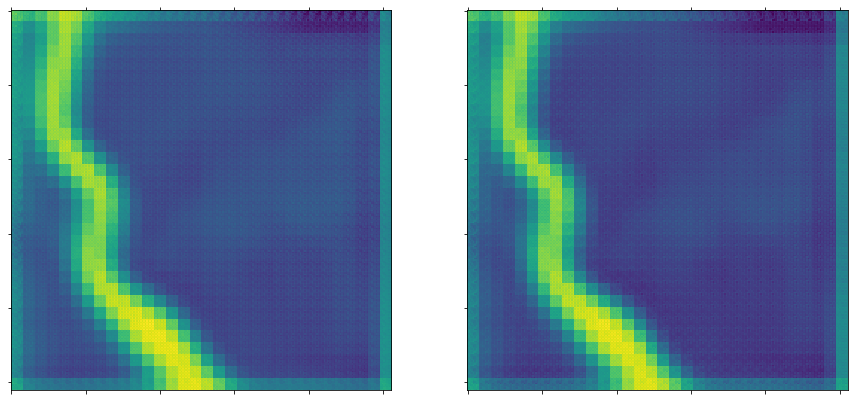

[1,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.277
[2,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.211
[3,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.173


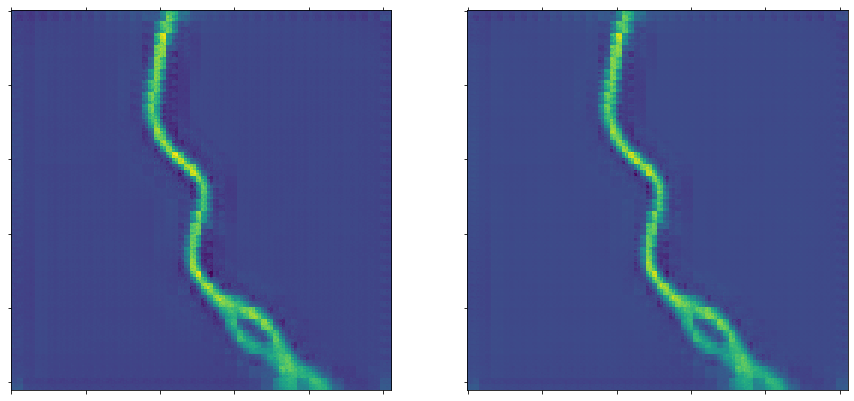

[4,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.148
[5,     2] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.130
[6,     6] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.117


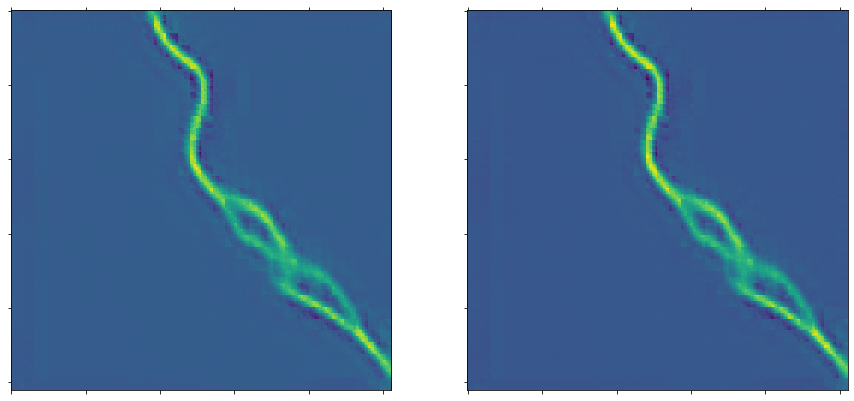

[7,    17] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.107
[8,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.099
[9,     5] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.092


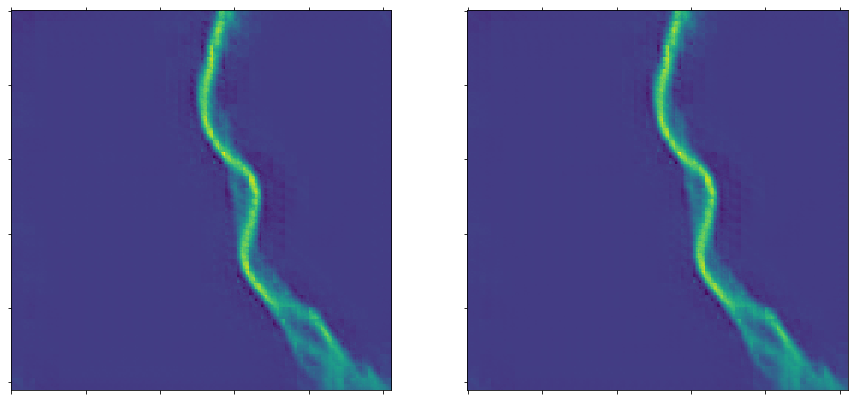

[10,    14] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.087
[11,    10] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.082
[12,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.078


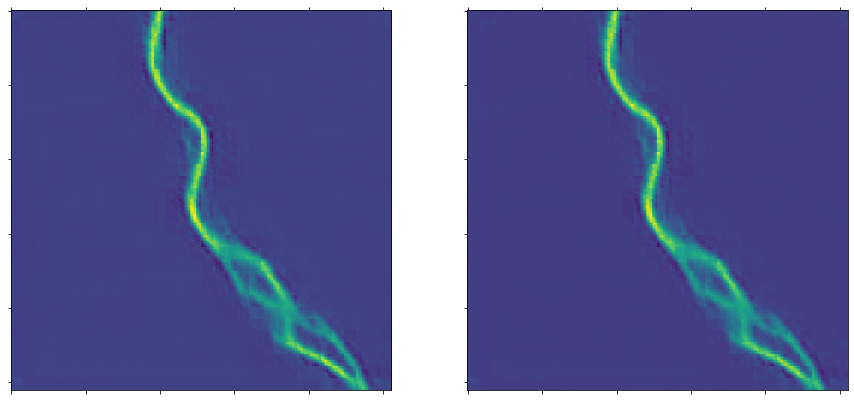

[13,    21] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.075
[14,    15] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.073
[15,     0] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.070


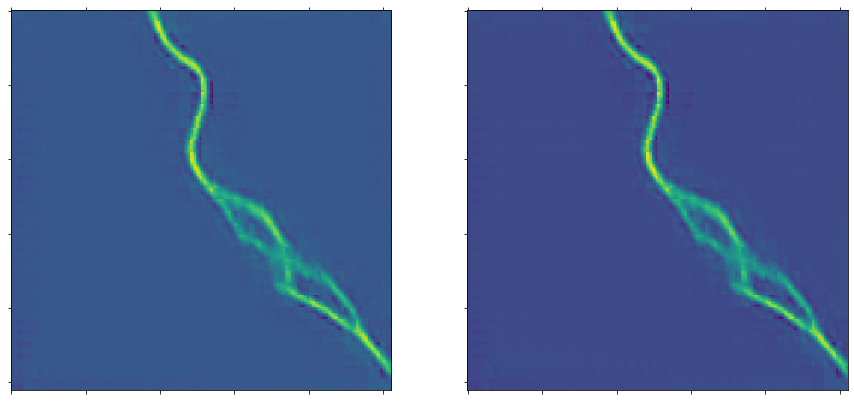

[16,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.068
[17,    17] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.065
[18,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.063


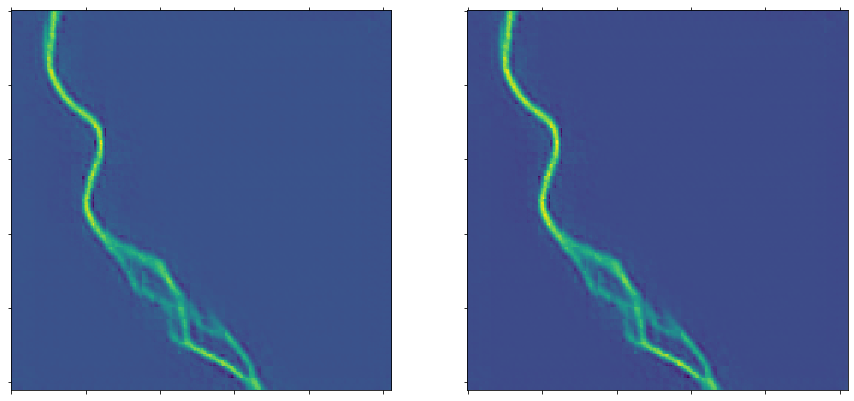

[19,     2] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.061
[20,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.060
[21,    16] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.058


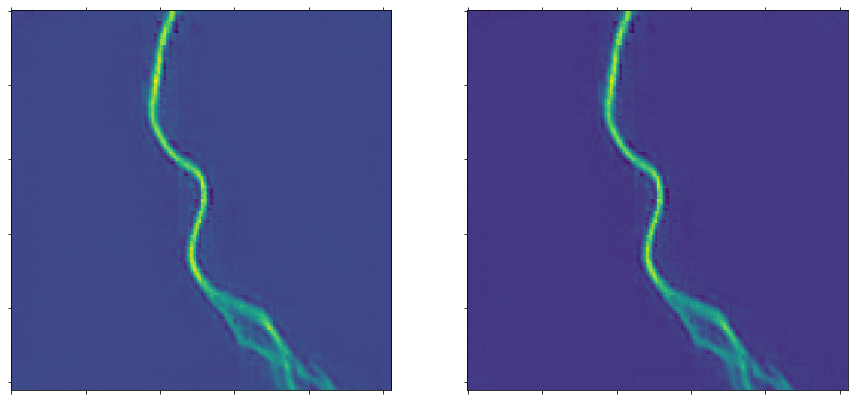

[22,    16] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.057
[23,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.055
[24,    17] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.054


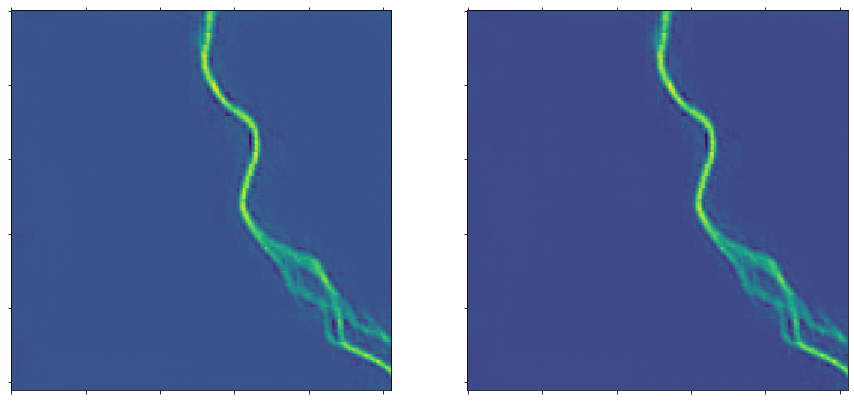

[25,    16] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.053
[26,    22] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.052
[27,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.050


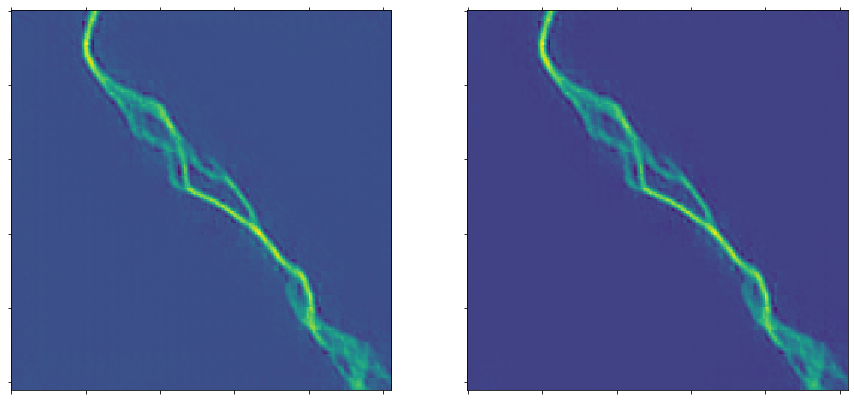

[28,    20] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.049
[29,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.049
[30,    19] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.048


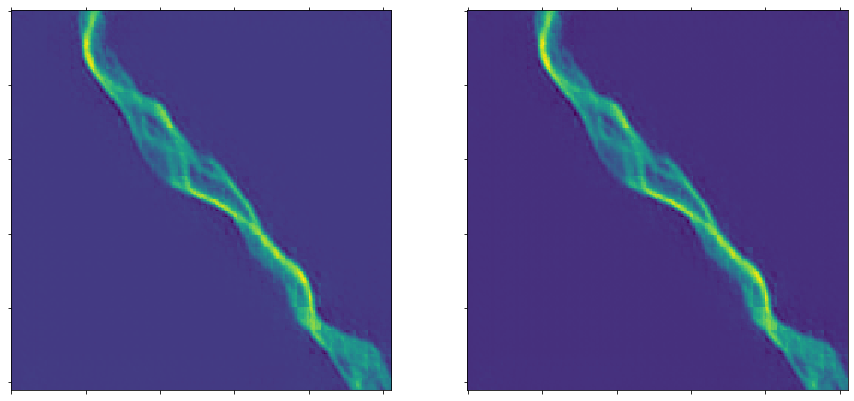

[31,     0] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.047
[32,    21] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.046
[33,    20] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.045


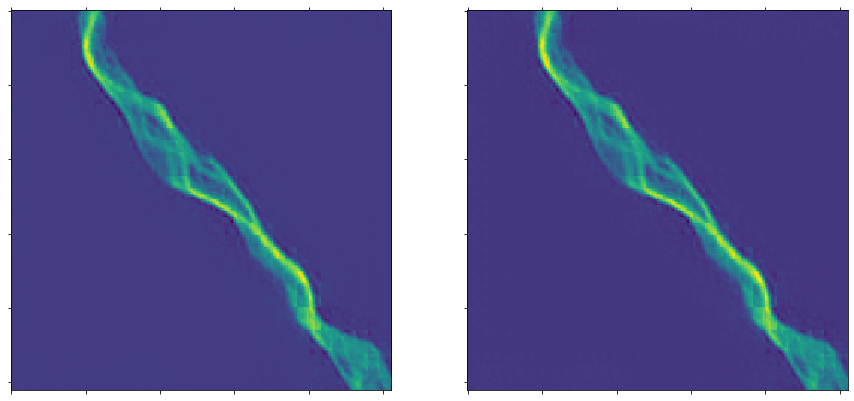

[34,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.045
[35,    22] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.044
[36,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.043


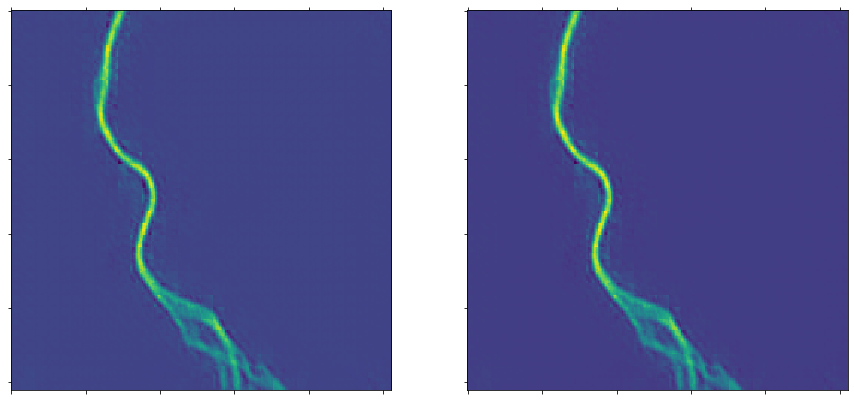

[37,    18] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.043
[38,     0] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.042
[39,    22] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.041


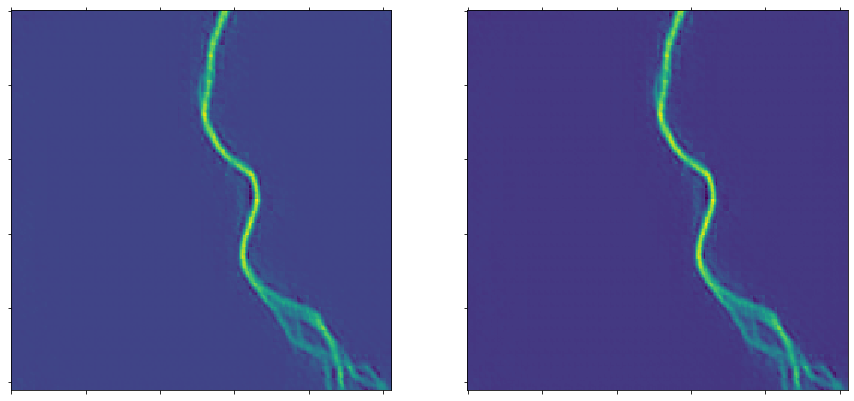

[40,    15] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.041
[41,    17] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.040
[42,     6] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.040


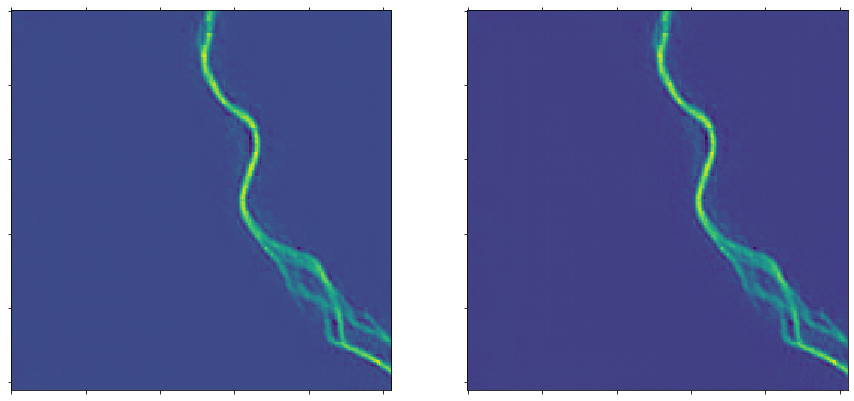

[43,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.039
[44,    19] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.039
[45,     9] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.038


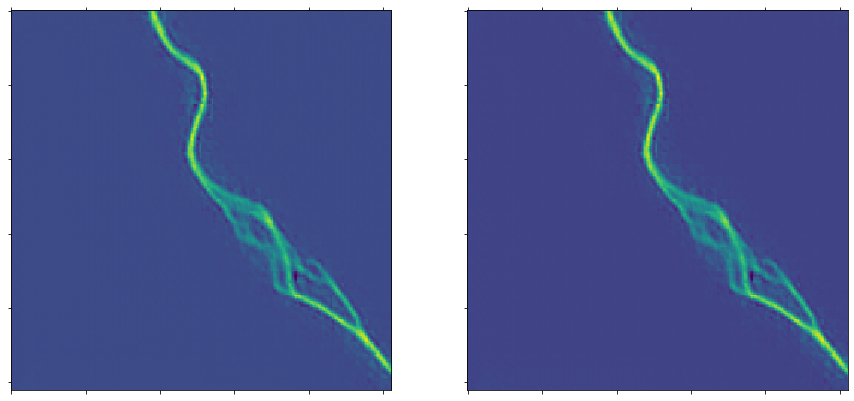

[46,    20] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.038
[47,    11] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.038
[48,    17] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.037


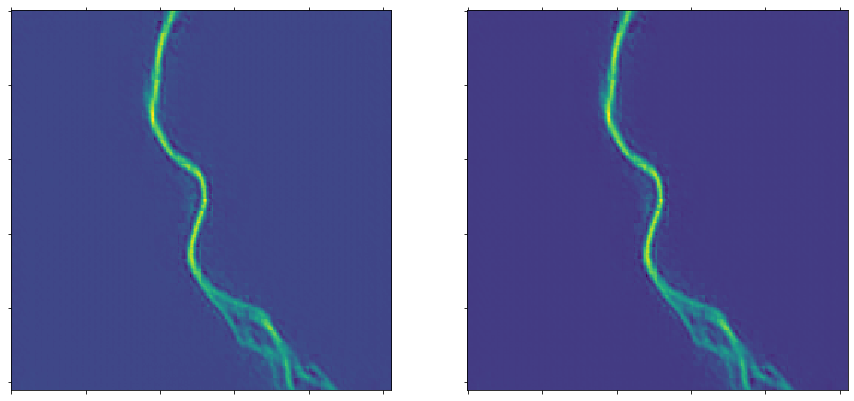

[49,    21] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.037
[50,    16] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.036
[51,    19] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.036


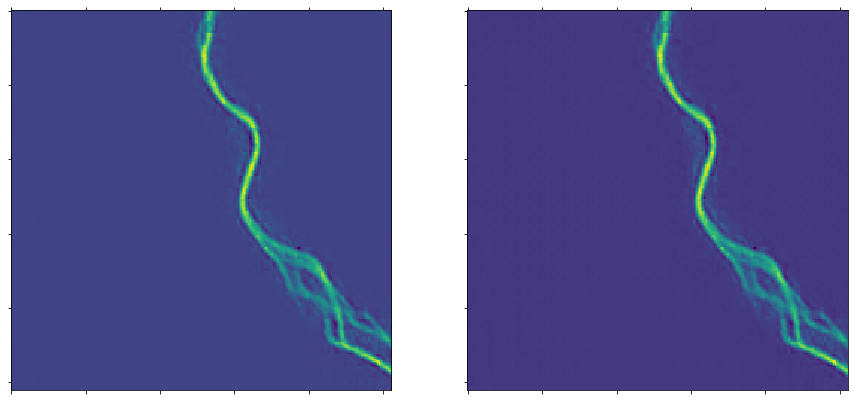

[52,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.036
[53,    19] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.035
[54,    20] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.035


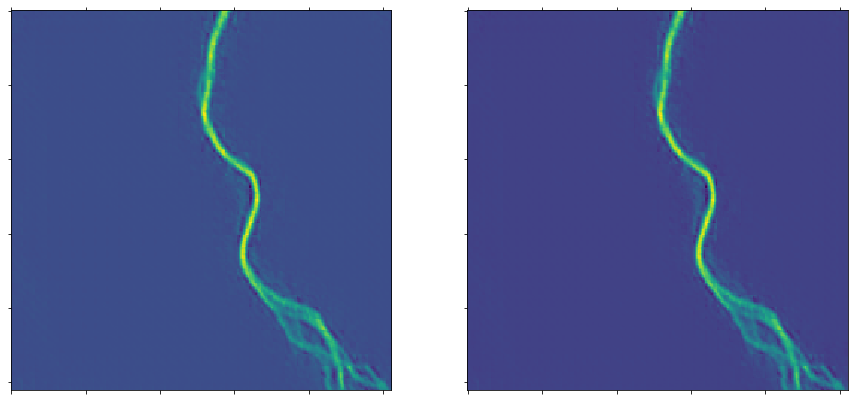

[55,    16] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.035
[56,    11] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.034
[57,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.034


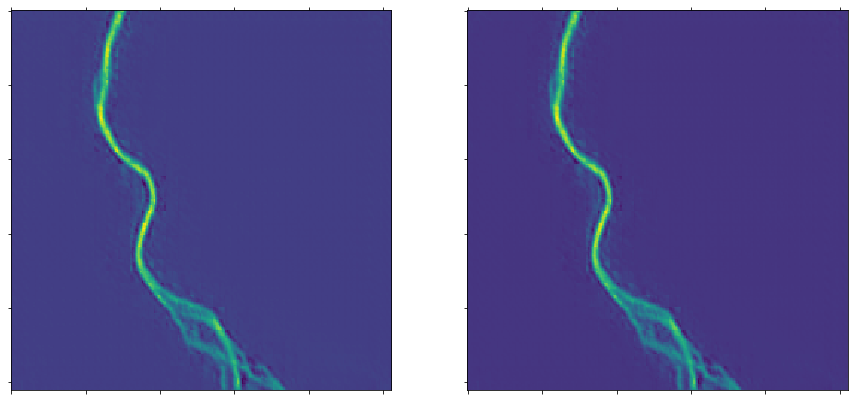

[58,    10] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.034
[59,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.033
[60,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.033


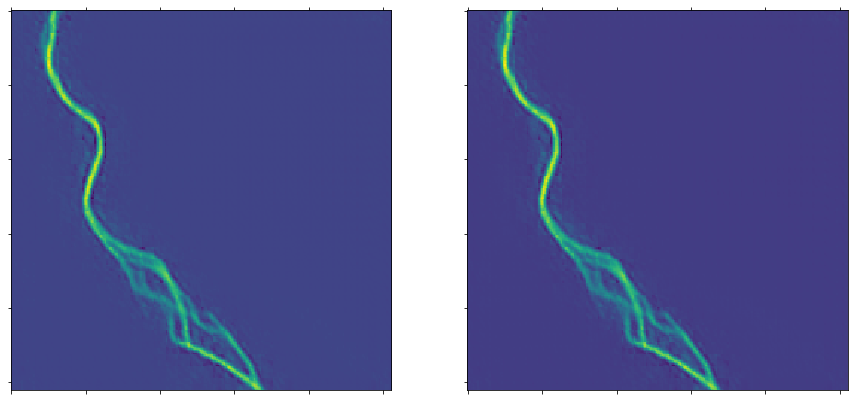

[61,    18] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.033
[62,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.033
[63,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.032


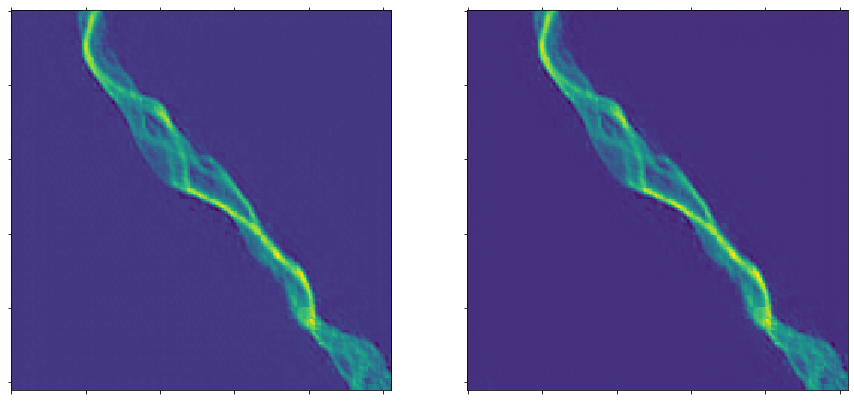

[64,    22] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.032
[65,     5] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.032
[66,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.032


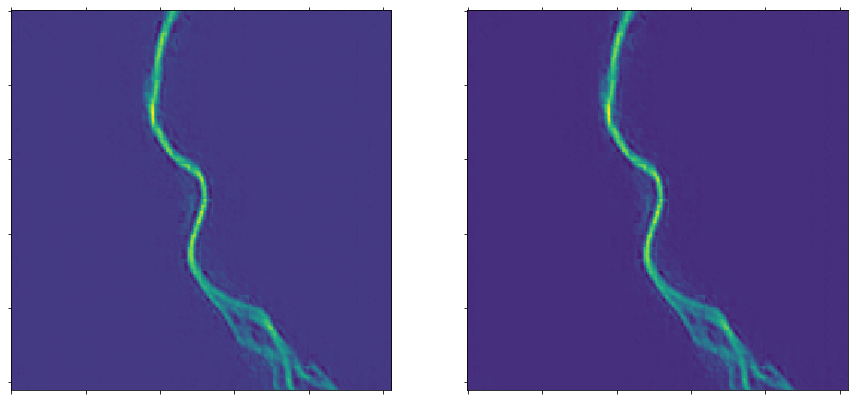

[67,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.031
[68,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.031
[69,    18] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.031


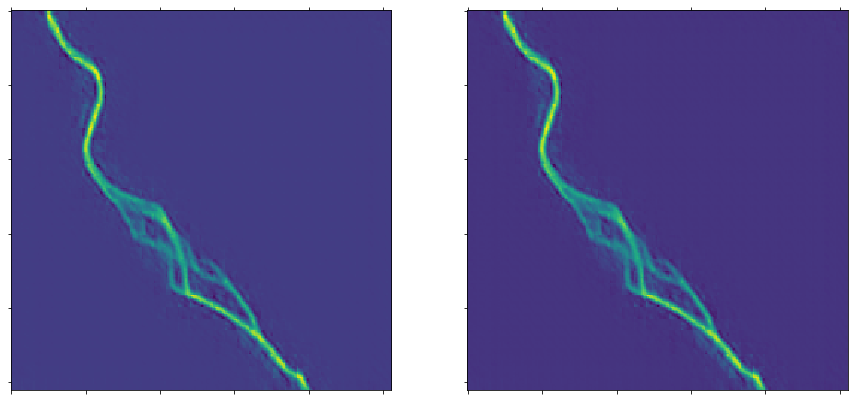

[70,     0] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.031
[71,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.031
[72,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.030


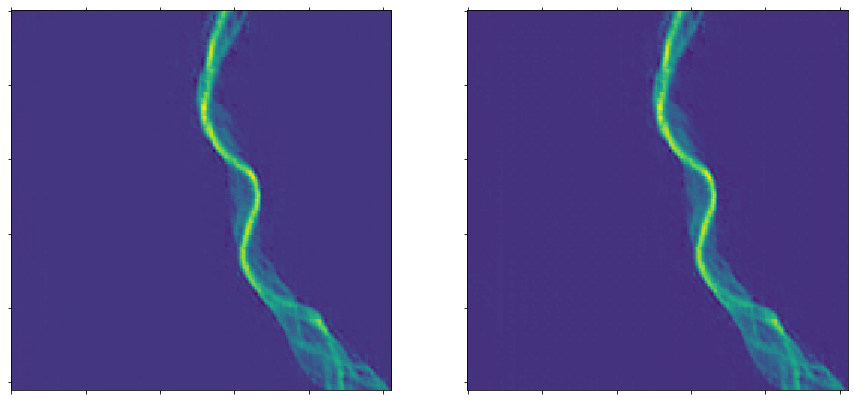

[73,     7] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.030
[74,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.030
[75,     6] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.030


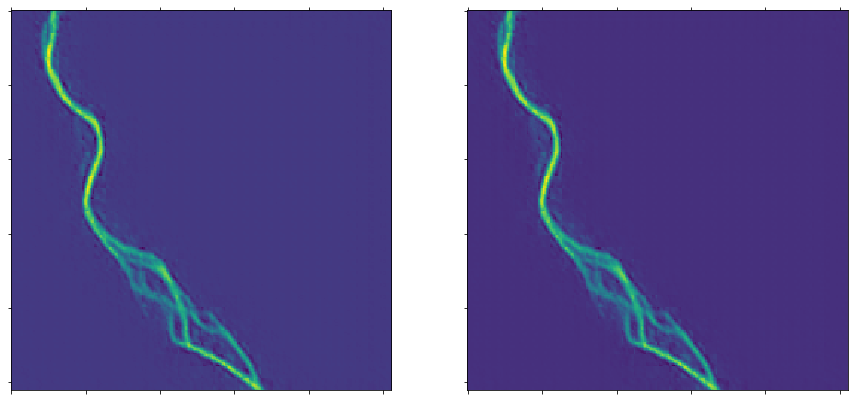

[76,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.030
[77,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.029
[78,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.029


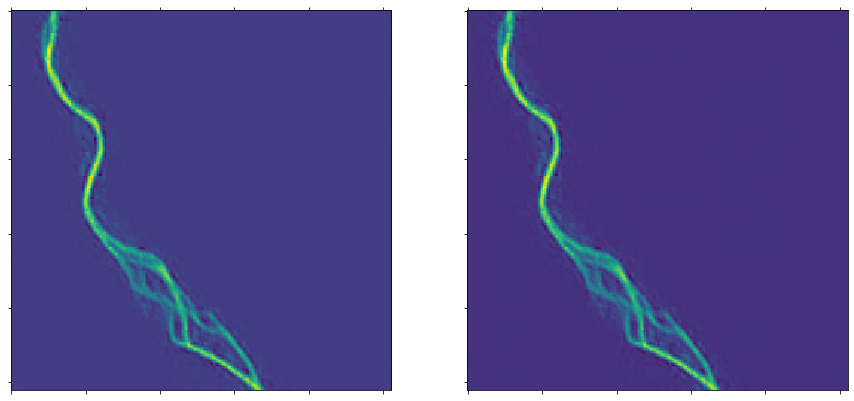

[79,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.029
[80,    16] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.029
[81,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.029


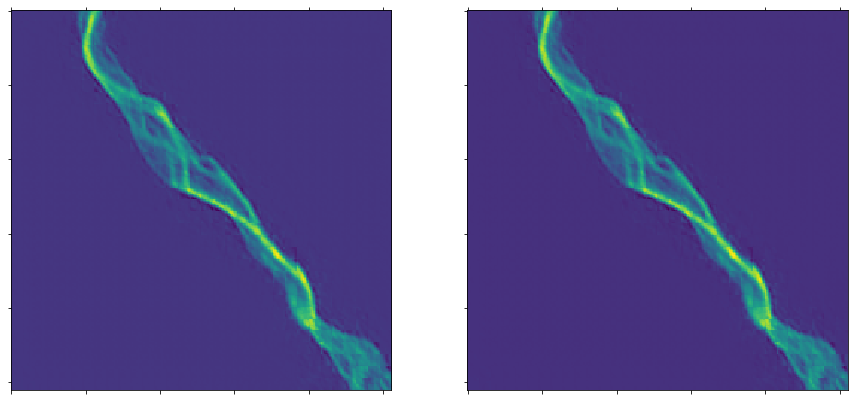

[82,    16] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.029
[83,     1] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.028
[84,     5] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.028


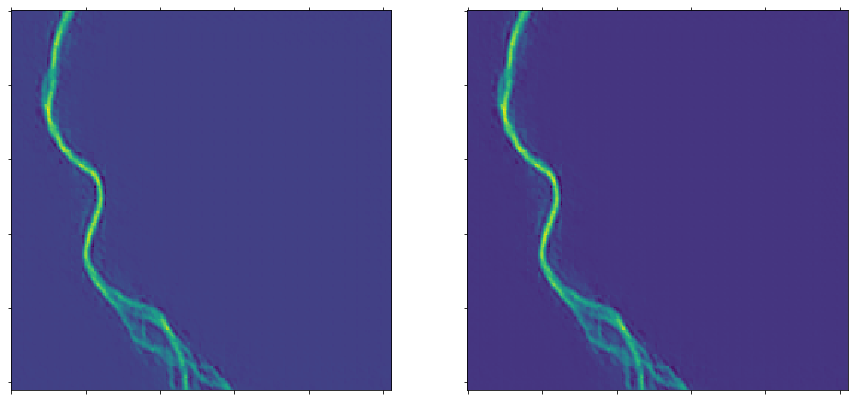

[85,     6] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.028
[86,     6] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.028
[87,    13] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.028


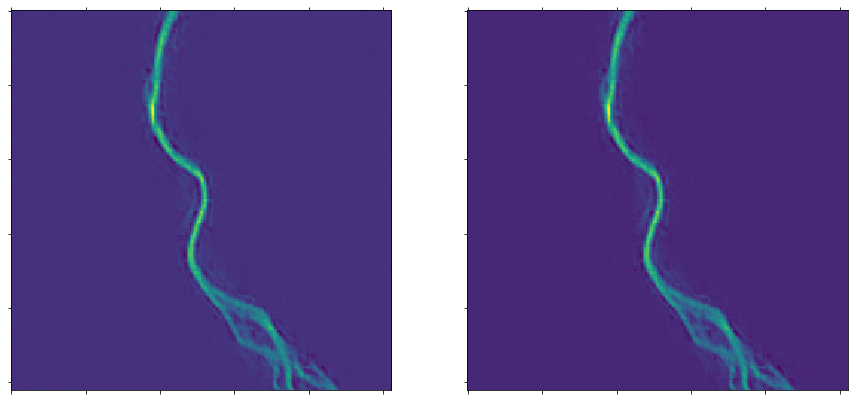

[88,    12] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.028
[89,     3] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.028
[90,    19] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.027


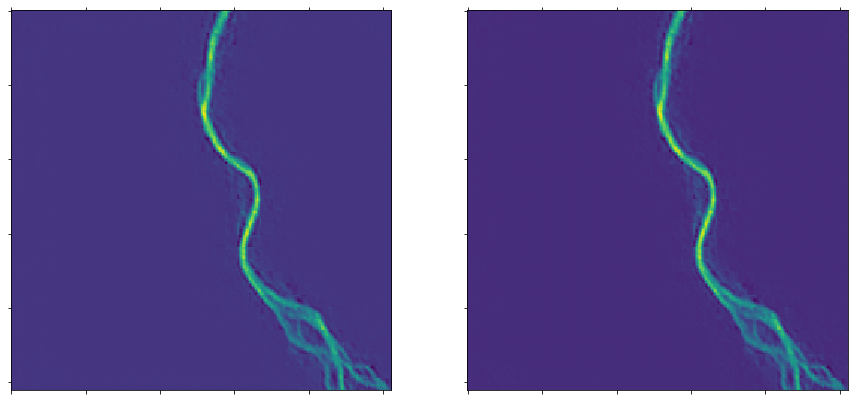

[91,    20] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.027
[92,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.027
[93,     0] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.027


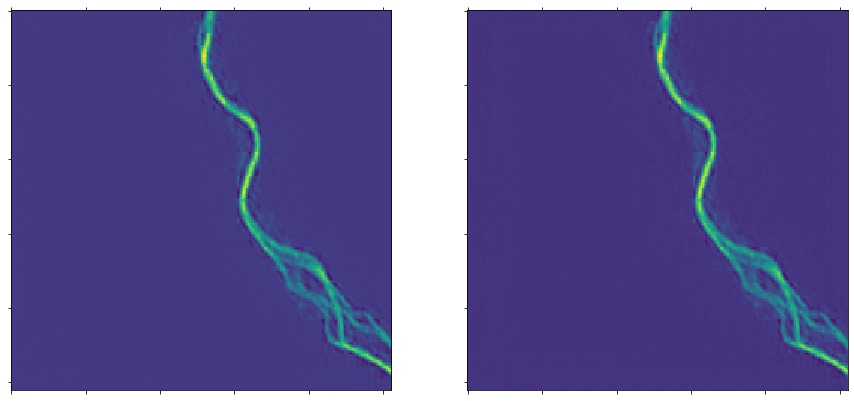

[94,     8] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.027
[95,     5] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.027
[96,     4] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.027


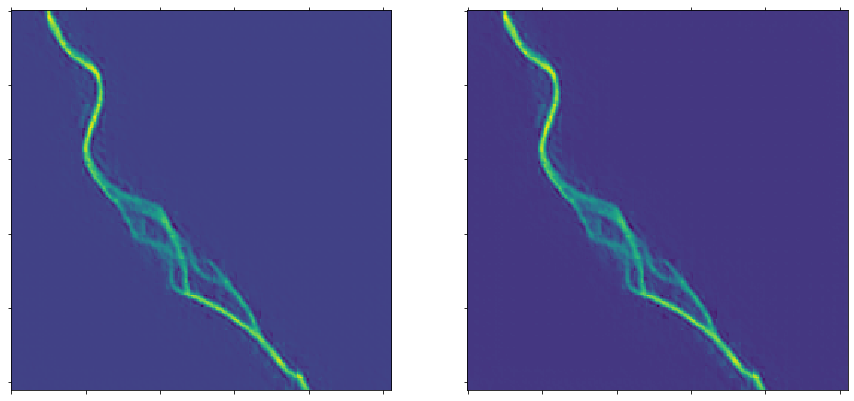

[97,    16] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.026
[98,    18] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.026
[99,    15] train_err: 0.000 	  test_err: 0.000 	 avg_loss: 0.026


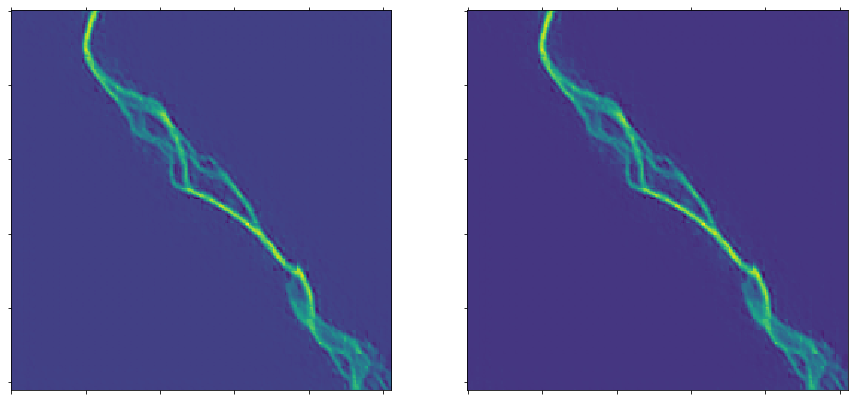

Finished Training


In [32]:
epochs = 100

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        outputs = net(batch)
        
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        losses.append(loss.item())

        # print("batch {} - loss {}".format(i, loss.item()))

        if i == len(X_train)-1:
            # randomly pick a test batch and compute it
            i = np.random.randint(len(y_test), size=1)
            
            train_out = net(X_test[i][0])
            test_out = net(X_train[i][0])
            
            #train_err = reverse_ssim(train_out, y_train[i]).item()
            #test_err = reverse_ssim(test_out, y_test[i]).item()
            train_err = 0
            test_err = 0

            test_errors.append(test_err)
            errors.append(train_err)
            
            print('[%d, %5d] train_err: %.3f \t  test_err: %.3f \t avg_loss: %.3f' %
                  (epoch, i, train_err, test_err, np.mean(losses)))

    if epoch % 3 == 0:
        i = np.random.randint(len(X_test))
        outputs = net(X_test[i])

        #------------------------------
        fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        for i,frame in enumerate(outputs[0,0]):
            axs[i].matshow(frame.cpu().detach().numpy())

        plt.show()
        #------------------------------

        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

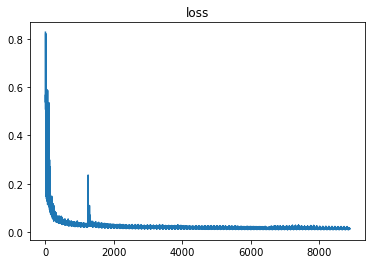

In [33]:
plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

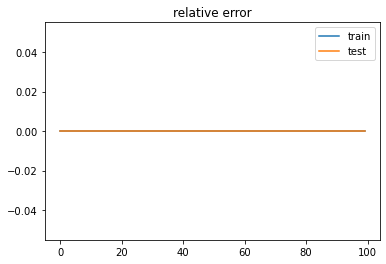

In [34]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


In [35]:
import matplotlib as mpl

mpl.rcParams['text.color'] = 'w'


k = 16
======== Past frames ========


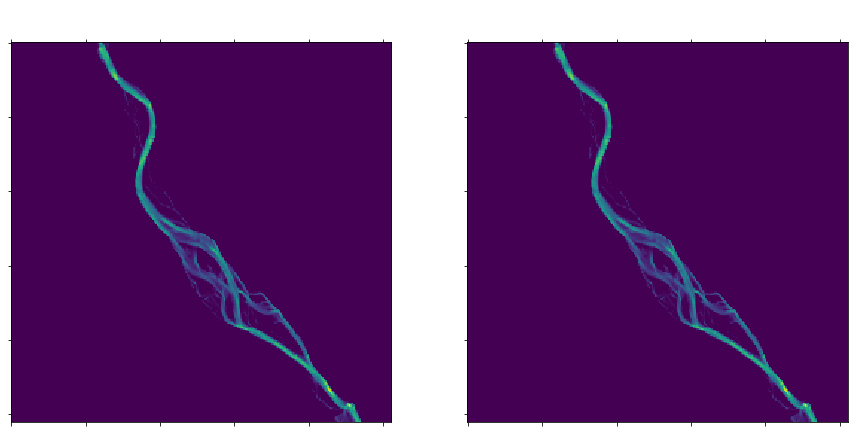

======== True Future vs Predicted frames ========


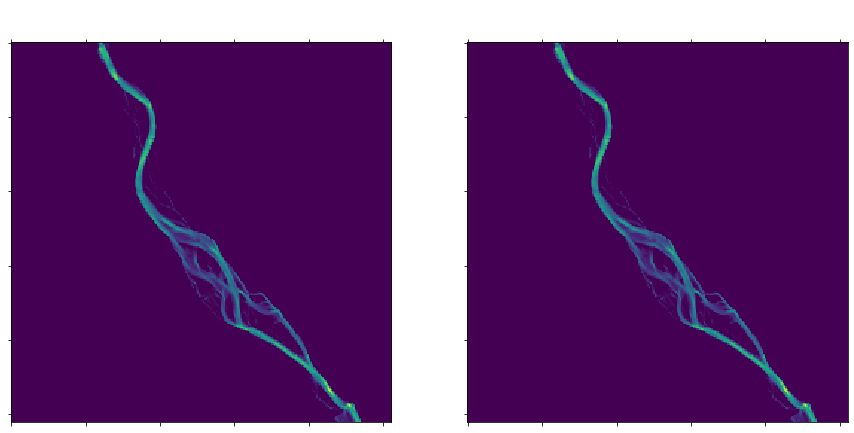

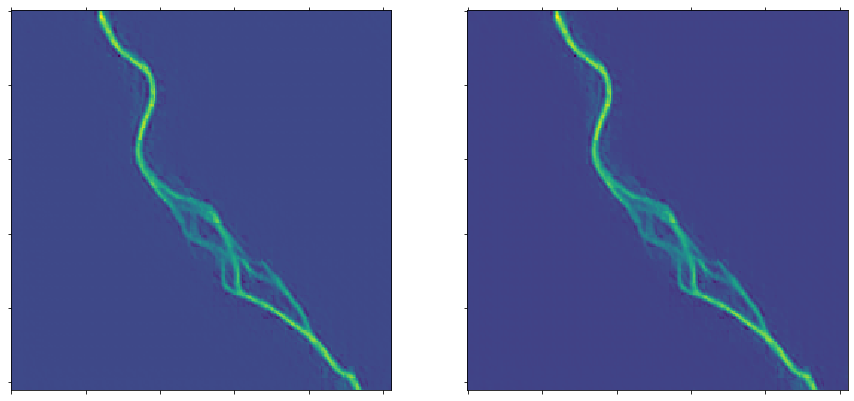

In [36]:
k = np.random.randint(len(X_train))
print("k = {}".format(k))
#k = 5
input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    frame = frame.cpu().detach().numpy()
    axs[i].matshow(frame)
    axs[i].set_title('t = {}'.format(i))

print("======== Past frames ========")
plt.show()

print("======== True Future vs Predicted frames ========")

#------------------------------
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_train[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))

plt.show()
#------------------------------
fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(outputs[0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())

plt.show()
#------------------------------

k = 16
======== Past frames ========


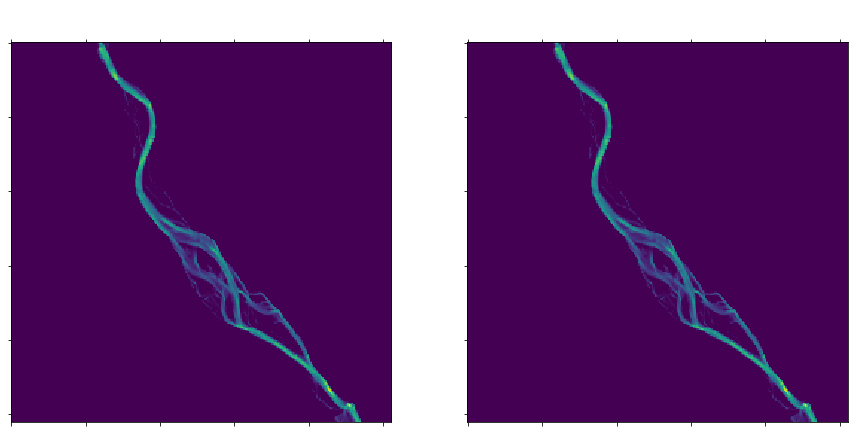

======== True vs Autoregressive Pred Frames  ========


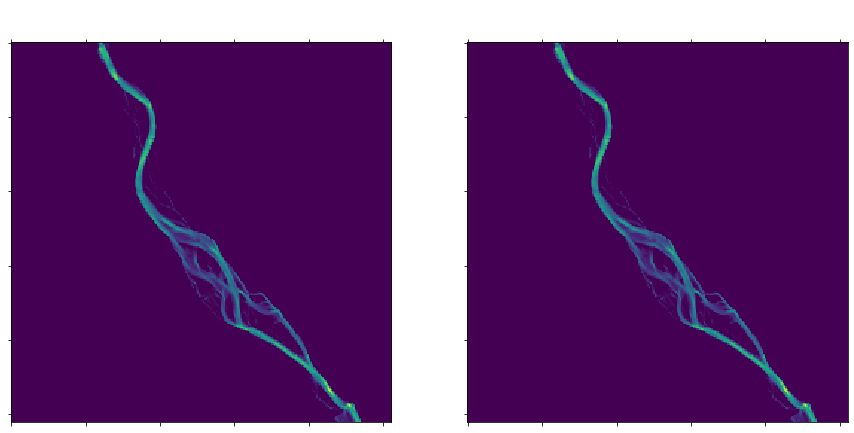

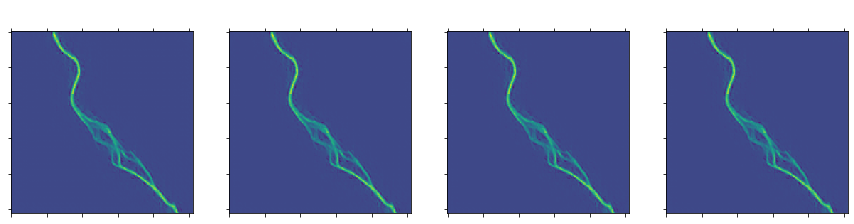

In [41]:
print("k = {}".format(k))
iterations = 4
#k = 5

input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
print("======== Past frames ========")
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i))

plt.show()
#------------------------------
print("======== True vs Autoregressive Pred Frames  ========")
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

true_means = []

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_train[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))
    true_means.append(frame.cpu().detach().numpy().mean())

plt.show()
#------------------------------

#i = np.random.randint(len(X_test))
input = th.unsqueeze(X_train[k][0], 0)

fig, axs = plt.subplots(1, iterations, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

predicted_means = []
for x in range(iterations):
    # first predicted frame only
    output = th.unsqueeze(net(input)[:,:,0,:,:],2)
    # next frame = first predicted from output + btm map
    next_frame = output.detach()
    next_frame = th.cat((next_frame, th.unsqueeze(input[:,2:,0,:,:],2)), axis=1)
    # added on top of (input sequence - first frame)
    input = th.cat((next_frame, input[:,:,1:,:]), axis=2)

    axs[x].matshow(output[0,0,0].cpu().detach().numpy())
    axs[x].set_title('t = {}'.format(x+num_predicted_frames))
    predicted_means.append(output[0,0,0].cpu().detach().numpy().mean())
    #print(np.mean(output[0,0,0].cpu().detach().numpy()))

plt.show()

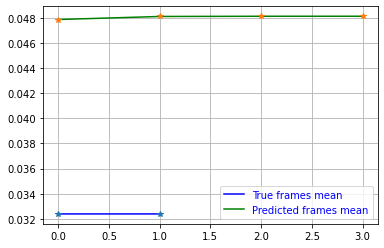

In [58]:
mpl.rcParams['text.color'] = 'b'

plt.clf()
plt.plot(range(len(true_means)), true_means,  "-b", label="True frames mean")
plt.plot(range(len(true_means)), true_means,  "*")

plt.plot(range(len(predicted_means)), predicted_means,  "-g", label="Predicted frames mean")
plt.plot(range(len(predicted_means)), predicted_means,  "*")
plt.grid()
plt.legend()
pass

In [59]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))


                    min                 max                 mean                std                 
prediction          -0.629627           4.727986            0.093293            0.405489            
true                0.000000            6.866364            0.196557            0.733532            
